In [57]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import wikipedia
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC

Let's try to get some model iterations going on, and let's improve that accuracy!

We left off with a decision tree classifier

In [2]:
df = pd.read_csv('../data/final_plots.csv').drop('Unnamed: 0', axis=1)
df.sample(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,plots
3444,Virtua Tennis 4,Wii,2011.0,Sports,Sega,0.05,0.08,0.0,0.01,0.14,65.0,15.0,7.5,4.0,Sega,E,The game supports the PlayStation Move control...
2811,Spartan: Total Warrior,PS2,2005.0,Action,Sega,0.11,0.09,0.0,0.03,0.22,74.0,33.0,8.4,65.0,Creative Assembly,M,"It is 300 BC, and the Roman army is in the mid..."
3563,Surf Riders,PS,1999.0,Sports,Ubisoft,0.07,0.05,0.0,0.01,0.13,64.0,6.0,tbd,NaN,ACOT,E,Surf Riders is a game in which the player is s...
4026,Spider-Man: Edge of Time,Wii,2011.0,Action,Activision,0.06,0.02,0.0,0.01,0.09,62.0,9.0,5.2,6.0,Beenox,T,The game begins with Peter Parker/Spider-Man b...
4723,Alienators: Evolution Continues,GBA,2001.0,Action,Activision,0.03,0.01,0.0,0.00,0.03,54.0,4.0,tbd,NaN,Digital Eclipse,E,"As with the film, the premise of the series is..."


In [3]:
def success(value):
    '''
    function for binning the critic scores
    '''
    
    if value > 60:
        if value > 75:
            return 2
        return 1
    return 0

In [4]:
df['success'] = df.Critic_Score.apply(success)

In [5]:
df.success.value_counts()

1    1949
2    1919
0    1275
Name: success, dtype: int64

In [6]:
y = df[['success']]
X = df[['plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)

In [8]:
dt = DecisionTreeClassifier()
dt.fit(X_train_tf, y_train)

DecisionTreeClassifier()

In [9]:
print('train acc: ', dt.score(X_train_tf, y_train))
print('test acc: ', dt.score(X_test_tf, y_test))

train acc:  0.9211822660098522
test acc:  0.5793157076205288


Alright so we've got our decision tree classifier, and surprise! we're way overfit

It's not a bad place to start though, almost 60% accuracy with a 3-class classifier

### Model 2

What I'd like to do next is to lemmatize the words before vectorizing. Undoubtedly we're getting some different conjugations and word tenses muddying up our data. We'll modify our clean_text function to lemmatize the words as well

In [10]:
def clean_text(text):
    import string
    wnl = WordNetLemmatizer()
    words = [''.join(ch for ch in s if ch not in string.punctuation) for s in text.split()]
    words = [wnl.lemmatize(word) for word in words]
    return ' '.join(words).lower()

In [11]:
df.plots = df.plots.apply(clean_text)
df.plots[100]

'princess peach is held captive in her castle by bowser bowser jr and the koopalings who invade and use a giant mechanical arm to throw mario luigi and two toads far away mario and friend must now travel across this new land returning to peachs castle in order to save her on the way they encounter seven koopalings each controlling their own world plus kamek nabbit bowser jr and many minor monster like goomba by conquering them they get closer to peachs castle which ha been transformed into an evil reflection of bowser by defeating bowser the castle return to normal as the hero celebrate bowser jr and the koopalings attempt to escape almost leaving bowser behind he manages to jump up onto the airship but his weight cause it to crash and they are forced to flee on bowser jrs koopa clown car'

Now there's no punctuation, and the words have been slightly lemmatized...? 

**note** I'm not too happy with the lemmatizer, words like 'conquering' 'returning' 'held', I thought it would deal with those

Let's try our decision tree again

In [12]:
y = df[['success']]
X = df[['plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
tf = TfidfVectorizer(stop_words='english', max_features=2000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train_tf, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [14]:
print('train acc: ', dt.score(X_train_tf, y_train))
print('test acc: ', dt.score(X_test_tf, y_test))

train acc:  0.9268861809696656
test acc:  0.5839813374805599


Grabbing that one percent, alright

### Model 3

Let's try a naive bayes classifier...the big guns

In [15]:
nb = MultinomialNB()

In [16]:
nb.fit(X_train_tf, y_train.values.ravel())

MultinomialNB()

In [17]:
print('train acc: ', nb.score(X_train_tf, y_train))
print('test acc: ', nb.score(X_test_tf, y_test))

train acc:  0.6546538760694841
test acc:  0.5248833592534993


So that's worse, I think because the multinomial naive Bayes algorithm is best suited to deal with the integer features of count-vectorized language.

let's just see if that helps

In [18]:
cv = CountVectorizer(max_features=2000)
X_train_cv = cv.fit_transform(X_train.plots)
X_test_cv = cv.transform(X_test.plots)

In [19]:
nb.fit(X_train_cv, y_train.values.ravel())

MultinomialNB()

In [20]:
print('train acc: ', nb.score(X_train_cv, y_train))
print('test acc: ', nb.score(X_test_cv, y_test))

train acc:  0.5569095151672284
test acc:  0.45023328149300157


*It was worth a shot, alright!?*

### Model 4

Now I'd like to try a random forest classifier....the *really* big guns

First we'll just see what the vanilla classifier can do here

In [21]:
tf = TfidfVectorizer(stop_words='english', max_features=3000, ngram_range=(1,2))
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tf, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced')

In [22]:
print('train acc: ', rf.score(X_train_tf, y_train))
print('test acc: ', rf.score(X_test_tf, y_test))

train acc:  0.9266269121078559
test acc:  0.6306376360808709


Eeking out those percentages once again


In [23]:
svc = SVC()
svc.fit(X_train_tf, y_train.values.ravel())

SVC()

In [24]:
print('train acc: ', rf.score(X_train_tf, y_train))
print('test acc: ', rf.score(X_test_tf, y_test))

train acc:  0.9266269121078559
test acc:  0.6306376360808709


### Time to blow it up with a *mean* grid search

In [25]:
params = {'C': [.2, .5, 1],
          'kernel': ['poly', 'linear'],
          'class_weight': ['balanced', None]}
svc = SVC()
gs = GridSearchCV(svc, params)


In [26]:
# gs.fit(X_train_tf, y_train.values.ravel())

In [28]:
# gs.best_params_

In [29]:
# gs.best_estimator_.score(X_test_tf, y_test)

In [30]:
feature_array = np.array(tf.get_feature_names())
tfidf_sorting = np.argsort(X_train_tf.toarray()).flatten()[::-1]

n = 100
top_n = feature_array[tfidf_sorting][:n]

In [31]:
top_n

array(['barry', 'adam', 'manages', 'store', 'hive', 'rain', 'flower',
       'car', 'picture', 'apartment', 'owner', 'human', 'head', 'job',
       'life', 'outside', 'kill', 'rest', 'decides', 'plan', 'group',
       'farm', 'associate', 'thinking', 'la', 'named', 'fend',
       'gain access', 'conversation', 'smash', 'called', 'disguise',
       'food', 'teach', 'best friend', 'prompting', 'prove', 'arcade',
       'movie', 'defeat', 'bringing', 'notice', 'escape', 'factory',
       'sneak', 'secretly', 'changed', 'suit', 'came', 'truck',
       'evidence', 'duel', 'stealing', 'fails', 'safe', 'case', 'send',
       'rescuing', 'cover', 'talk', 'squad', 'trick', 'arriving',
       'racing', 'doing', 'getting', 'focus', 'defense', 'finish',
       'train', 'skill', 'new', 'collect', 'fly', 'access', 'chase',
       'stage', 'video', 'best', 'hold', 'bring', 'working', 'playing',
       'entire', 'remaining', 'want', 'star', 'party', 'agent', 'arrive',
       'house', 'capture', 'gain'

In [32]:
tfidf_sorting

array([ 234,   44, 1637, ..., 1992, 1991,    0], dtype=int64)

In [33]:
np.argsort(X_train_tf.toarray())

array([[   0, 1991, 1992, ...,  991, 1624, 1139],
       [   0, 1944, 1945, ..., 1503, 2843, 2566],
       [   0, 1971, 1972, ..., 2301, 1973,  915],
       ...,
       [   0, 1982, 1983, ..., 1672, 1218,  265],
       [   0, 1989, 1990, ..., 2125,  144, 2983],
       [   0, 1975, 1976, ..., 1637,   44,  234]], dtype=int64)

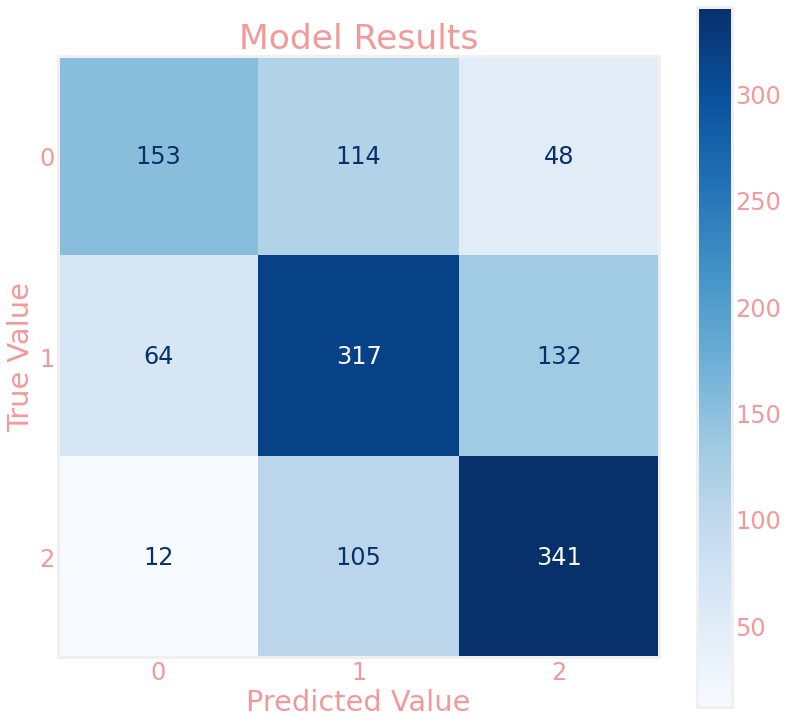

In [34]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 24
plt.rc_context({ 'xtick.color':'#F59899', 'ytick.color':'#F59899', 'figure.facecolor':'white'})
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(rf, X_test_tf, y_test, cmap='Blues', ax=ax);
ax.set_ylabel('True Value', color='#F59899')
ax.set_title('Model Results', color='#F59899')

ax.set_xlabel('Predicted Value', color='#F59899')
ax.grid(False)
plt.savefig('../src/figures/confusion.png', transparent=True)

## Exploration Tangent

I would like to explore document normalization. This is the idea that when you have multiple documents in your corpus of varying lengths, it can affect your vectorization by making the vectors of longest documents have a higher magnitude. I think I got that right. 

Let's see how long our documents are

In [37]:
df.plots.apply(lambda x: len(x.split())).describe()

count    5143.000000
mean      419.355240
std       321.381298
min         7.000000
25%       157.000000
50%       348.000000
75%       633.000000
max      3085.000000
Name: plots, dtype: float64

**God dang,** we have one that is 7 words long and one that is over 3000 words long... that could be a problem

In [40]:
X_train_tf[0].sum()

4.755889345250454

In [53]:
from sklearn.preprocessing import normalize
normed = normalize(X_train_tf, norm='max', axis=1)
normed_test = normalize(X_test_tf, norm='max', axis=1)

In [54]:
normed[0].sum()

17.636446932639327

In [55]:
svc = SVC()
svc.fit(normed, y_train.values.ravel())

SVC()

In [56]:
print('train acc: ', svc.score(normed, y_train))
print('test acc: ', svc.score(normed_test, y_test))

train acc:  0.9209229971480425
test acc:  0.6236391912908242


In [68]:
stops = stopwords.words('english')
more_stops = ['game', 'gameplay', 'players', 'win', 'battle']
stops += more_stops

In [71]:
tf = TfidfVectorizer(stop_words=stops, max_features=3000, ngram_range=(1,2))
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tf, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced')

In [72]:
print('train acc: ', rf.score(X_train_tf, y_train))
print('test acc: ', rf.score(X_test_tf, y_test))

train acc:  0.9266269121078559
test acc:  0.6283048211508554
